* FAT: Forget about time
* Delta: Predict (x\* - last MidPrice) rather than x\*

In [1]:
import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import StandardScaler

In [2]:
nGiven = 10
nPredict = 15
nFeature = 7

In [4]:
train_csv = pd.read_csv('mdLog.csv', usecols=list(range(1, 7)))  # lastprice, volume, bidsize, bid, ask, asksize

'''timestamp = []
for i in range(nRows):
    dt = time.strptime(train_csv['Date'][i] + ' ' + train_csv['Time'][i], "%Y-%m-%d %H:%M:%S")
    dt_new = time.mktime(dt)
    timestamp.append(dt_new)'''

'timestamp = []\nfor i in range(nRows):\n    dt = time.strptime(train_csv[\'Date\'][i] + \' \' + train_csv[\'Time\'][i], "%Y-%m-%d %H:%M:%S")\n    dt_new = time.mktime(dt)\n    timestamp.append(dt_new)'

In [5]:
train_csv['midprice'] = (train_csv['ask'] + train_csv['bid']) / 2

In [6]:
mid_price = np.array(train_csv['midprice']).astype(np.float64)

In [7]:
x_raw = np.array(train_csv.values).astype(np.float64)

In [8]:
X = []
y = []

fake_point = 0
volume_sum = 0
volume_len = 0

noise_flag = True

for k in range(len(train_csv) - nGiven - nPredict):
    if k%10000==0:
        print(k,end = '\r')
    x_cur = x_raw[k: k+nGiven].copy()
    last_mp = x_cur[nGiven-1, -1]
    # 将所有与Price相关的变量都减去并除以最后一条数组的中间价。这样就可以将量纲完全消除。
    for axis in [-1, 0, 3, 4]: # MidPrice, LastPrice, BidPrice1, AskPrice1
        x_cur[:,axis] -= last_mp
        x_cur[:,axis] /= last_mp

    # 将每一组Volume数据减去上一条信息的Volume，将这个特征转化为：3秒内累计成交数量。至此，每组/条数据的Volume便为同一分布了。
    for i in range(nGiven-1, 0, -1):
        x_cur[i, 1] -= x_cur[i-1, 1]
        volume_sum += x_cur[i,1]
        volume_len += 1
    x_cur[0, 1] = volume_sum / volume_len  # 对于第一条数据，没有办法得知它与上一条数据（没有给出）的差值，只能用均值填充。具体方法是利用迄“今”（这条数据）为止得到的Volume插值的均值。
    
    if noise_flag:
        x_cur *= (1 + 0.001 * (np.random.rand(nGiven, nFeature) - 0.5) * 2)  # 加入噪声
    
    #if timestamp[k+nGiven+nPredict] - timestamp[k]> (3*(nGiven+nPredict)): 
    #    fake_point+=1
    #else:
    #    token = True
    #    for i in range(nGiven+nPredict-1):
    #        if timestamp[k+1+i] - timestamp[k+i] != 3:
    #            token = False
    #            break
    #    if token:
    X.append(x_cur)
    y.append((np.mean(mid_price[k+nGiven: k+nGiven+nPredict]) - mid_price[k+nGiven-1]) / mid_price[k+nGiven-1])
    #    else:
    #        fake_point+=1

In [13]:
X = np.array(X).astype(np.float64)
y = np.array(y).astype(np.float64)
y = y.reshape((-1,1))

In [19]:
X.shape

(50209, 10, 7)

In [21]:
X[:1]

array([[[-3.73216029e-04,  3.79728558e+01,  4.54887803e+02,
         -7.46897710e-04,  0.00000000e+00,  9.99109299e-01,
         -3.73212320e-04],
        [-3.73533189e-04,  0.00000000e+00,  4.55250168e+02,
         -7.47139860e-04,  0.00000000e+00,  9.99234209e-01,
         -3.73620511e-04],
        [-7.46350508e-04,  5.79537883e+01,  5.18281661e+02,
         -7.46462804e-04, -3.72987140e-04,  9.99641039e-01,
         -5.60061739e-04],
        [ 0.00000000e+00,  1.29875100e+01,  4.20379949e+01,
         -3.73121639e-04,  0.00000000e+00,  4.40095317e+01,
         -1.86708184e-04],
        [ 0.00000000e+00,  3.90178064e+01,  1.63016964e+02,
         -7.46988756e-04,  3.72931173e-04,  1.99800809e+00,
         -1.86750009e-04],
        [-3.73447198e-04,  9.89459552e+01,  1.74002333e+02,
         -7.46824041e-04,  0.00000000e+00,  2.80018926e+01,
         -3.73591594e-04],
        [-3.73108745e-04,  7.60394322e+01,  3.85692401e+02,
         -7.47285783e-04, -3.73309862e-04,  9.99279956e+00

降维以标准化

In [16]:
X_tmp = X.reshape(-1, nFeature)

In [18]:
X_tmp.shape

(502090, 7)

In [22]:
X_tmp[:1]

array([[-3.73216029e-04,  3.79728558e+01,  4.54887803e+02,
        -7.46897710e-04,  0.00000000e+00,  9.99109299e-01,
        -3.73212320e-04]])

In [23]:
x_scaler = StandardScaler()
X_tmp_norm = x_scaler.fit_transform(X_tmp)  # 标准化

恢复原来的维度

In [24]:
X_norm = X_tmp_norm.reshape(-1, nGiven, nFeature)

In [25]:
X_norm.shape

(50209, 10, 7)

In [26]:
if not noise_flag:
    assert(X_norm[0][1][1]==X_norm[0][2][1])

对于预测值的处理

In [27]:
y_std = np.std(y)
y_mean = np.mean(y)

In [28]:
y_norm = (y - y_mean) / y_std

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.05, random_state=42)
print(X_train.shape)
print(y_train.shape)

(47698, 10, 7)
(47698, 1)


In [32]:
model = Sequential()
model.add(LSTM(units=256, input_shape=(None, nFeature), dropout=0.5, return_sequences=True))
model.add(LSTM(units=256, dropout=0.5, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer="uniform", activation='linear'))
model.compile(loss='mse', optimizer='Adam')

In [31]:
batch_size = 128
epochs = 12

In [34]:
hists = []
hist = model.fit(X_train, y_train, 
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data=(X_test,y_test))
hists.append(hist)

Epoch 1/12
373/373 [==============================] - 14s 38ms/step - loss: 0.9137 - val_loss: 0.8721
Epoch 2/12
373/373 [==============================] - 20s 55ms/step - loss: 0.8924 - val_loss: 0.8489
Epoch 3/12
373/373 [==============================] - 28s 75ms/step - loss: 0.8871 - val_loss: 0.8345
Epoch 4/12
373/373 [==============================] - 13s 35ms/step - loss: 0.8786 - val_loss: 0.8301
Epoch 5/12
373/373 [==============================] - 13s 34ms/step - loss: 0.8697 - val_loss: 0.8209
Epoch 6/12
373/373 [==============================] - 13s 34ms/step - loss: 0.8614 - val_loss: 0.8296
Epoch 7/12
373/373 [==============================] - 13s 34ms/step - loss: 0.8593 - val_loss: 0.8471
Epoch 8/12
373/373 [==============================] - 13s 35ms/step - loss: 0.8597 - val_loss: 0.8341
Epoch 9/12
373/373 [==============================] - 13s 36ms/step - loss: 0.8565 - val_loss: 0.8270
Epoch 10/12
373/373 [==============================] - 13s 34ms/step - loss: 0.849

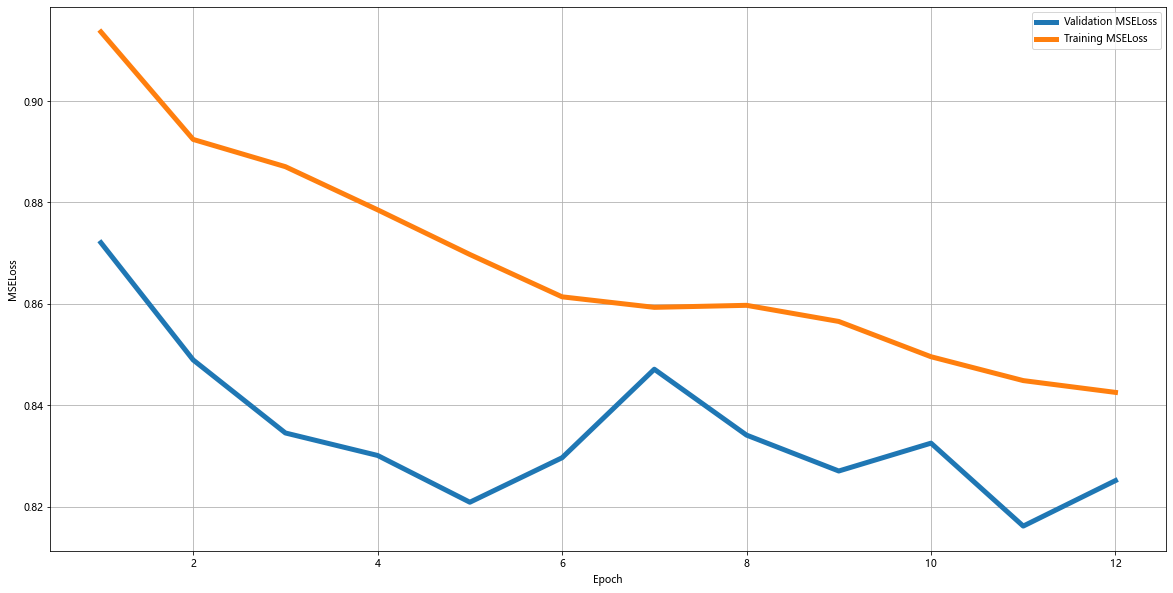

In [35]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(20, 10))
axs.plot(hist_df['val_loss'], lw=5, label='Validation MSELoss')
axs.plot(hist_df['loss'], lw=5, label='Training MSELoss')
axs.set_ylabel('MSELoss')
axs.set_xlabel('Epoch')
axs.grid()
axs.legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [ ]:
filename = os.path.join(INPUT_DIR, 'test_data.csv')
test_csv = pd.read_csv(filename)

In [ ]:
nRows_test = 10000

In [ ]:
index = ['MidPrice','LastPrice','Volume','BidPrice1','BidVolume1','AskPrice1','AskVolume1']
test_ds = test_csv[index]
mid_price_test = np.array(test_csv['MidPrice']).astype(np.float64)
x_test_raw = np.array(test_ds.values).astype(np.float64)

In [ ]:
X_test = []
mid_price_batch_test = []
volume_sum_test = 0
volume_len_test = 0
for k in range(int(nRows_test/nGiven)):
    x_cur = x_test_raw[k*nGiven:k*nGiven+nGiven].copy()
    last_mp = x_cur[nGiven-1,0]
    for axis in [0,1,3,5]: # MidPrice, LastPrice, BidPrice1, AskPrice1
        x_cur[:,axis] -= last_mp
        x_cur[:,axis] /= last_mp

    for i in range(9,0,-1):
        x_cur[i,2]-=x_cur[i-1,2]
        volume_sum_test+=x_cur[i,2]
        volume_len_test+=1
    x_cur[0,2]=volume_sum_test/volume_len_test
    
    X_test.append(x_cur)
    mid_price_batch_test.append(mid_price_test[k*10+nGiven-1])

In [ ]:
X_test = np.array(X_test).astype(np.float64)
X_test = X_test.reshape(-1,nGiven,nFeature)
mid_price_batch_test = np.array(mid_price_batch_test).astype(np.float64).reshape(-1,1)

In [ ]:
X_tmp_test = X_test.reshape(-1,nFeature)
X_tmp_norm_test = x_scaler.transform(X_tmp_test)
X_norm_test = X_tmp_norm_test.reshape(-1,nGiven,nFeature)

In [ ]:
y_test_pred = model.predict(X_norm_test)

In [ ]:
y_test_pred = y_test_pred.reshape(-1,1)

In [ ]:
result = y_test_pred * mid_price_batch_test * y_std + y_mean + mid_price_batch_test

In [ ]:
offset = 142

In [ ]:
result_offset = result[offset:int(nRows_test/10)]

In [ ]:
submission = pd.DataFrame({'caseid':list(range(offset+1,1001)),'midprice':result_offset.reshape(-1,)})

In [ ]:
submission.to_csv('submission', index=False)
submission.head()